In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")

import anndata
from scipy.stats import spearmanr, pearsonr
import numpy as np
from PIL import Image
import matplotlib

from digitalhistopathology.clustering.clustering_utils import plot_ari_scores_all_patients
import warnings

# Suppress all UserWarning messages
warnings.filterwarnings("ignore", category=UserWarning)

Image.MAX_IMAGE_PIXELS = None
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

2025-12-02 08:10:02.632482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-12-02 08:10:02.632603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-12-02 08:10:02.632611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
# Load configuration
with open("../../config/config_notebooks_Ovarian.json", "r") as config_file:
    config = json.load(config_file)

In [3]:
from digitalhistopathology.benchmark.benchmark_clustering import BenchmarkClustering

# Initialize the BenchmarkClustering object

saving_folder=os.path.join(config['base_benchmark_folder'], "unsupervised_clustering_ARI", "kmeans")
extension='pdf'


benchmark_clustering = BenchmarkClustering(path_to_pipeline=config['path_to_base_pipelines'],
                                           pipelines_list=config['base_model_list'],
                                           results_folder="../../results",
                                           saving_folder=saving_folder,
                                           dataset=config['dataset'],
                                           extension=extension, 
                                           
                                           )

/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/stlearn/tl/cci/het.py:206: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


['uni']
<class 'list'>
Label files: []


In [4]:
a = config["base_color_palette"]
sns.set_palette(a)
base_model_palette = config["base_model_palette"]

base_model_list = config["base_model_list"]
benchmark_folder = config["base_benchmark_folder"]

## Create Figure2 folder
if not os.path.exists(os.path.join(config['figures_folder'], "Figure2")):
    os.makedirs(os.path.join(config['figures_folder'], "Figure2"))

## Create Figure3 folder
if not os.path.exists(os.path.join(config['figures_folder'], "Figure3")):
    os.makedirs(os.path.join(config['figures_folder'], "Figure3"))

## Create Figure4 folder
if not os.path.exists(os.path.join(config['figures_folder'], "Figure4")):
    os.makedirs(os.path.join(config['figures_folder'], "Figure4"))
    
## Create Figure5 folder
if not os.path.exists(os.path.join(config['figures_folder'], "Figure5")):
    os.makedirs(os.path.join(config['figures_folder'], "Figure5"))

In [5]:
benchmark_clustering.saving_folder

'../../results/Ovarian/benchmark/base_models/unsupervised_clustering_ARI/kmeans'

## Comparison between linear and unlinear clustering

In [6]:
raw_clust = benchmark_clustering.unsupervised_clustering_benchmark(n_clusters=None, clustering_name='raw')

svd_clust = benchmark_clustering.unsupervised_clustering_benchmark(n_clusters=None, clustering_name='svd5')

umap_clust = benchmark_clustering.get_best_UMAP_ari_per_slide(force_loading=True)

## Add handcrafted features once computed
import glob
umap_clust["handcrafted_features"] = {}
for file in glob.glob(os.path.join(benchmark_clustering.saving_folder, f'best_umap_ari_model_handcrafted_features_patient_*.json')):
    patient_name = os.path.basename(file).split("_patient_")[1].split('.json')[0]
    with open(file, 'r') as f:
        umap_clust["handcrafted_features"][patient_name] = json.load(f)


Loading unsupervised clustering results for model uni...
Loading unsupervised clustering results for model uni...
Embeddings per patient: None
Force loading best UMAP parameters for model uni for existing patients...
Force loading best UMAP parameters for model handcrafted_features for existing patients...


In [7]:
for model in raw_clust.keys():
    print(f"Model: {model}: ari all: {raw_clust[model]['all']['ari']}, ari mean: {raw_clust[model]['mean']['ari']}")

Model: uni: ari all: 0.16401708972974682, ari mean: 0.29221268122819694


In [8]:
for model in raw_clust.keys():
    print(f"Model: {model}: ari tumor: {raw_clust[model]['ARI_tumor']}")

Model: uni: ari tumor: 0.17282401568224678


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


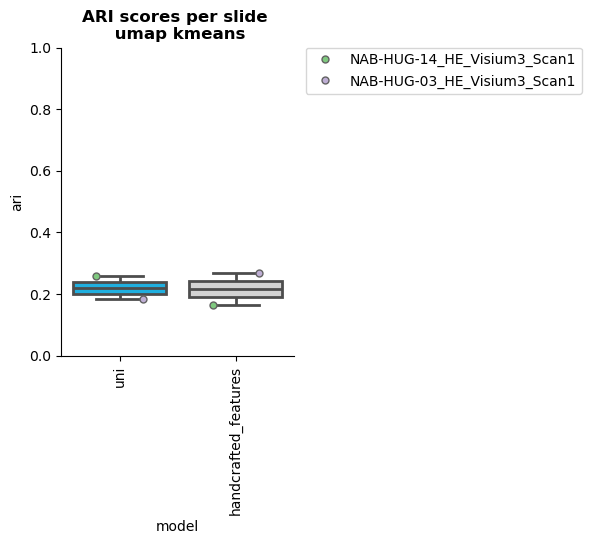

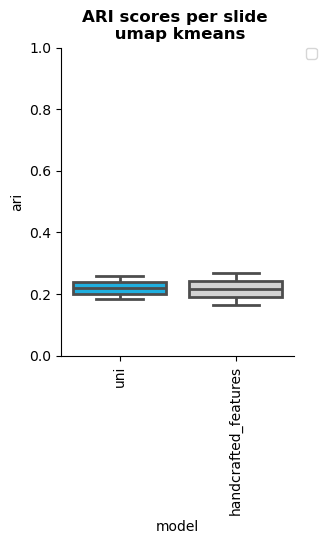

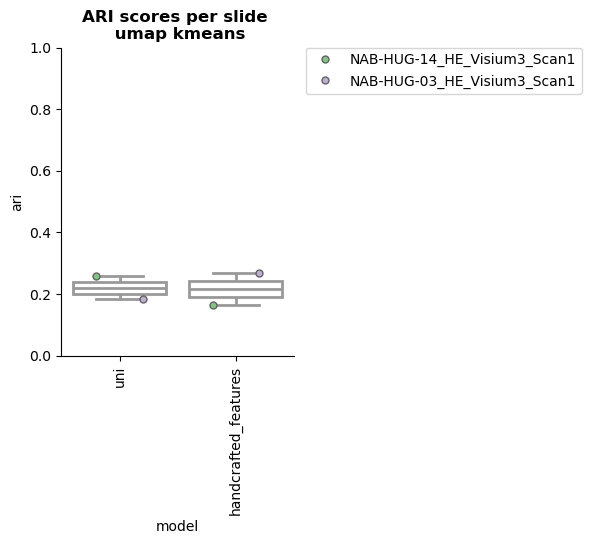

In [9]:
# for clust_dict, clust_name in zip([raw_clust, svd_clust, umap_clust], ["raw", "svd", "umap"]):

plt.figure(figsize=(3,4))
plot_ari_scores_all_patients(umap_clust, model_list=umap_clust.keys(), color_boxes=True, palette=base_model_palette)
plt.ylim(0, 1)
plt.title(f"ARI scores per slide \n umap kmeans", weight='bold')
# plt.savefig(os.path.join(config["figures_folder"],"Figure2/ARI_scores_boxplot_umap_kmeans_colored_with_patient.pdf"), bbox_inches='tight')
if len(umap_clust[base_model_list[0]]) > 15:
    plt.legend().remove()
    
plt.figure(figsize=(3,4))
plot_ari_scores_all_patients(umap_clust, model_list=umap_clust.keys(), stripplot=False, color_boxes=True, palette=base_model_palette)
plt.ylim(0, 1)
plt.title(f"ARI scores per slide \n umap kmeans", weight='bold')
# plt.savefig(os.path.join(config["figures_folder"],"Figure2/ARI_scores_boxplot_umap_kmeans_colored_without_patient.pdf"), bbox_inches='tight')
if len(umap_clust[base_model_list[0]]) > 15:
    plt.legend().remove()
    
plt.figure(figsize=(3,4))
plot_ari_scores_all_patients(umap_clust, model_list=umap_clust.keys(), stripplot=True, color_boxes=False)
plt.ylim(0, 1)
plt.title(f"ARI scores per slide \n umap kmeans", weight='bold')
# plt.savefig(os.path.join(config["figures_folder"],"Figure2/ARI_scores_boxplot_umap_kmeans_no_color_with_patient.pdf"), bbox_inches='tight')
if len(umap_clust[base_model_list[0]]) > 15:
    plt.legend().remove()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'ARI scores per slide \n UMAP k-means')

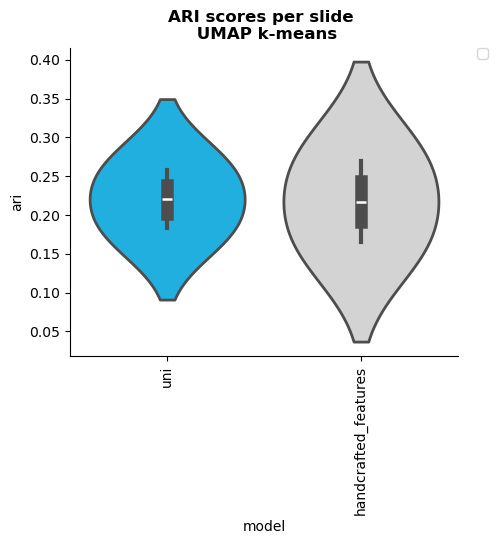

In [10]:
ari_scores = {}
for model in umap_clust.keys():
    ari_scores[model] = {}
    for patient in umap_clust[model].keys():
        if (patient != 'all') and (patient != 'mean'):
            ari_scores[model][patient] = umap_clust[model][patient]['ari']
df_aris = pd.DataFrame.from_dict(ari_scores)
df_aris_melted = pd.melt(df_aris, var_name='model', value_name='ari')
df_aris_melted['patient'] = df_aris.index.to_list()*len(df_aris.columns)

plt.figure(figsize=(5,4))
sns.violinplot(data=df_aris_melted, x='model', y='ari', hue='model', linewidth=2, palette=base_model_palette)


plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.title(f'ARI scores per slide \n UMAP k-means', weight='bold')

Text(0.5, 1.0, 'Distribution of ARI scores for unsupervised clustering \n n_patient=2')

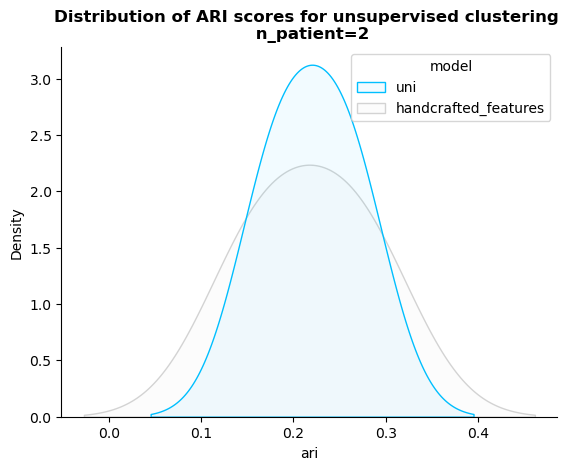

In [11]:
sns.kdeplot(data=df_aris_melted, x='ari', hue='model', fill=True, alpha=0.05, palette=base_model_palette)
sns.despine()
plt.title(f'Distribution of ARI scores for unsupervised clustering \n n_patient={len(list(umap_clust[list(umap_clust.keys())[0]].keys()))}', weight='bold')

In [12]:
# Scatter plot

In [13]:
dfs_clust = []
for clustering_dict, method in zip([raw_clust, svd_clust, umap_clust], ["raw", "svd", "umap"]):
#for clustering_dict, method in zip([umap_clust], ["umap"]):
    ari_scores = {}
    for model in clustering_dict.keys():
        ari_scores[model] = {}
        for patient in clustering_dict[model].keys():
            if patient != "ARI_tumor":
            #if (patient != 'all') and (patient != 'mean'):
                ari_scores[model][patient] = clustering_dict[model][patient]['ari']
    df_aris = pd.DataFrame.from_dict(ari_scores)
    df_aris_melted = pd.melt(df_aris, var_name='model', value_name='ari')
    df_aris_melted['patient'] = df_aris.index.to_list()*len(df_aris.columns)
    df_aris_melted['clustering'] = method
    dfs_clust.append(df_aris_melted)

df_comp = pd.concat(dfs_clust)




In [14]:
df_comp

,model,ari,patient,clustering
0,uni,0.308308,NAB-HUG-03_HE_Visium3_Scan1,raw
1,uni,0.276118,NAB-HUG-14_HE_Visium3_Scan1,raw
2,uni,0.164017,all,raw
3,uni,0.292213,mean,raw
0,uni,0.307758,NAB-HUG-03_HE_Visium3_Scan1,svd
1,uni,0.274930,NAB-HUG-14_HE_Visium3_Scan1,svd
2,uni,0.150468,all,svd
3,uni,0.291344,mean,svd
0,uni,0.257459,NAB-HUG-14_HE_Visium3_Scan1,umap
1,uni,0.182887,NAB-HUG-03_HE_Visium3_Scan1,umap


In [15]:
df_comp[df_comp['clustering'] == 'raw'][['model', 'ari']].groupby('model').mean()

,ari
model,
uni,0.260164


In [16]:
df_comp[df_comp['clustering'] == 'raw'][['model', 'ari']].groupby('model').std()

,ari
model,
uni,0.065431


In [17]:
## Correlation with shannon entropy
import json 
with open(os.path.join(benchmark_folder, "shannon_entropy", "shannon_entropy_all_comps_raw.json")) as f:
    shannon_entropy = json.load(f)
    


In [18]:
shannon_entropy

{'uni': 0.39509515626660435, 'handcrafted': 0.02383988894748281}

(0.0, 0.6)

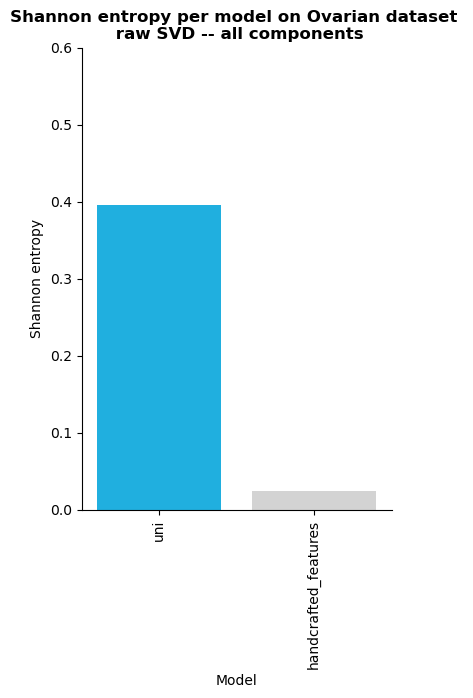

In [19]:
plt.figure(figsize=(4, 6))
df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])
df_shannon.rename(index={'handcrafted': 'handcrafted_features'}, inplace=True)

df_shannon.sort_values('shannon_entropy', inplace=True, ascending=False)
sns.barplot(data=df_shannon, 
            x=df_shannon.index, 
            y='shannon_entropy', 
            hue=df_shannon.index, palette=base_model_palette)
sns.despine()
plt.xlabel("Model")
plt.ylabel("Shannon entropy")
plt.title(f"Shannon entropy per model on {config['dataset']} dataset \n raw SVD -- all components", weight='bold')
plt.xticks(rotation=90)
plt.savefig(os.path.join(config['figures_folder'], "Figure2/shannon_entropy.pdf"), bbox_inches='tight')
plt.ylim(0, 0.6)

In [20]:
ari_raw = pd.DataFrame.from_dict({model: {patient: raw_clust[model][patient]['ari'] for patient in raw_clust[model].keys() if patient not in ["ARI_tumor"]} for model in raw_clust.keys()})
df_raw_overall = pd.DataFrame(ari_raw.loc["all"])
df_raw_overall.columns = ['ari']

In [21]:
ari_svd = pd.DataFrame.from_dict({model: {patient: svd_clust[model][patient]['ari'] for patient in svd_clust[model].keys()  if patient != 'ARI_tumor'} for model in svd_clust.keys()})
df_svd_overall = pd.DataFrame(ari_svd.loc["all"])
df_svd_overall.columns = ['ari']

In [22]:
ari_umap_overall = benchmark_clustering.get_best_UMAP_ari_overall()   

Computing best UMAP parameters for model uni...
Loading best UMAP parameters for model uni...


In [23]:


try:
    with open(os.path.join(config['base_benchmark_folder'], 'unsupervised_clustering_ARI', 'kmeans', f'best_umap_ari_overall.json')) as f:
        ari_umap_overall = json.load(f)
except:
    ari_umap_overall = benchmark_clustering.get_best_UMAP_ari_overall()
ari_umap_overall = benchmark_clustering.get_best_UMAP_ari_overall()   
df_umap_overall = pd.DataFrame(ari_umap_overall).T[['ari']]


Computing best UMAP parameters for model uni...
Loading best UMAP parameters for model uni...


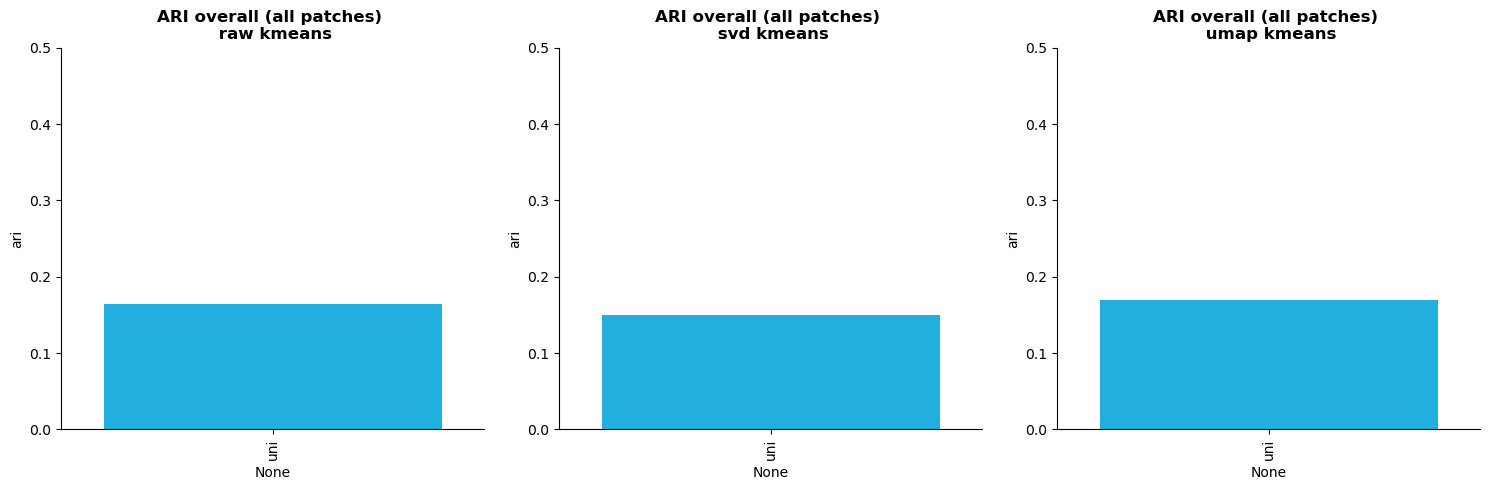

In [24]:
plt.figure(figsize=(15, 5))

names = ["raw kmeans", "svd kmeans", "umap kmeans"]

for i, df_ari_overall in enumerate([df_raw_overall, df_svd_overall, df_umap_overall]):
    plt.subplot(1, 3, 1 + i)
    sns.barplot(data=df_ari_overall.sort_values("ari", ascending=False), x=df_ari_overall.index, y="ari", hue=df_ari_overall.index, palette=base_model_palette)
    plt.xticks(rotation=90)
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 0.5)
    plt.title(f"ARI overall (all patches) \n {names[i]}", weight='bold')


plt.savefig(os.path.join(config['figures_folder'], "Figure2/unsupervised_clustering_raw_svd_umap_barplot.pdf"), bbox_inches='tight')

